In [1]:
import os
import torchvision

from torch import cuda, device, Tensor, save, load, stack, zeros, vstack
from src.plots import plot_vae_training_result, plot_image
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.image_classifier import MNISTClassifier
from src.utils import frechet_inception_distance
from src.sampling import split_dirichlet

device = device('cuda' if cuda.is_available() else 'cpu')

In [2]:
training_data = torchvision.datasets.MNIST(root='../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())
print(training_data)
print(testing_data)

input = training_data.data[:60000] / 255.0    # normalizing necessary to make pixels in [0, 1] range for FID
labels = training_data.targets[:60000]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST_train
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/MNIST_test
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
# parameters
model = "cvae"
dataset = "mnist"
batch_size = 100
epoch = 2
learning_rate = 0.001

model_path = f"/home/neo/projects/RP_data/models/{model}_{dataset}_{batch_size}_{epoch}_{learning_rate}.pt"

# TODO: add non-IID settings
# TODO: save plotting results
if os.path.exists(model_path):
    vae = load(model_path)
else:
    vae = ConditionalVae(dim_encoding=3).to(device)

    # try with model sigma
    vae_model, vae_loss_li, kl_loss_li = vae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epoch,
        learning_rate=learning_rate
    )
    save(vae, model_path)
    
    # move tensors to cpu before converting to np array
    np_kl_loss_li = []
    
    for output in kl_loss_li:
        if isinstance(output, Tensor):
            np_kl_loss_li.append(output.cpu().detach().numpy())
    
    # plot results
    plot_vae_training_result(
        input=input,
        labels=labels,
        vae_model=vae_model,
        vae_loss_li=vae_loss_li,
        kl_loss_li=np_kl_loss_li
    )

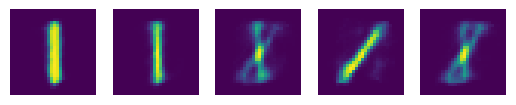

In [4]:
images = vae.generate_data(n_samples=5, target_label=1)
plot_image(images)

In [5]:
# train classifier for performance evaluation
model = "classifier"
dataset = "mnist"
batch_size = 64
epoch = 5

classifier_path = f"/home/neo/projects/RP_data/models/{model}_{dataset}_{batch_size}_{epoch}.pt"

if os.path.exists(classifier_path):
    classifier = load(classifier_path)
else:
    classifier = MNISTClassifier(input_size=784, num_classes=10)
    classifier.train_model(training_data, batch_size=batch_size, epochs=epoch)
    accuracy = classifier.test_model(testing_data)
    print("Test accuracy: ", accuracy)
    save(classifier, classifier_path)

In [6]:
# generate data for testing on classifier
# this one stays the same
data_count = 10000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(vae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())

final_images = vstack(images)
final_labels = vstack(labels)

assert final_images.shape[0] == final_labels.shape[0]

accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
print("Accuracy: ", accuracy)

Wrong count:  229
Accuracy:  0.9771


In [ ]:
# # Determine FID
# # generate 500 images
# syn_input, _ = vae.generate_data(n_samples=500)
# input = input[:500]
# 
# input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# 
# # compute FID score
# fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
# print("Frechet Inception Distance: ", fid_score)